# Finding Risings, Settings, and Culminations

This notebook describes functions that find times of risings/settings, and also times of culminations. Both of these functions work for ephemeris objects, `Star` objects, or `EarthSatellite` objects. I will also describe ways to test the times found by these functions. The tests show that for the cases tested the times found by `risings_settings` are within 1ms, and those found by `culminations` are within 6 ms.

The use of these functions is pretty simple and clean, for example here is the code to find the times of all sunrises in january 2018 from greenwich:

```
ephem = load('de430t.bsp')
earth = ephem['earth']
sun = ephem['sun']
greenwich = earth + Topos('51.5 N', '0 W')
time_range = ts.utc(2017, [1,2])

sunrise_times = risings_settings(greenwich, sun, timerange, kind='rise')[0]
```

## Imports
To start we'll import all the functions and classes we'll need, and create a few sample object to work with:

In [20]:
from scipy.optimize import brentq, minimize_scalar
from scipy.misc import derivative
from skyfield.api import Loader, Topos, Star, EarthSatellite, Time
from skyfield.constants import tau
from functools import partial
from numpy import arange, array, argsort, ndarray, repeat, concatenate, degrees, arcsin, linspace
from warnings import warn

load = Loader(r'C:\Users\Josh\Scripts\Skyfield_Data')

ts = load.timescale()

ephem = load('de430t.bsp')
earth = ephem['earth']
sun = ephem['sun']
moon = ephem['moon']
mars = ephem['mars barycenter']

satellites = load.tle(r'stations.txt')
ISS = earth + satellites['ISS']

greenwich = earth + Topos('51.5 N', '0 W')

## Functions that we'll need later
We'll create a function that will test if an object represents an `EarthSatellite`. It returns true for either an `EarthSatellite` object, or a `VectorSum` from the Solar System Barycenter to an `EarthSatellite` object, and false otherwise.

In [21]:
def _is_satellite(body):
    if isinstance(body, EarthSatellite):
        return True
    elif getattr(body, 'positives', ()) and isinstance(body.positives[-1], EarthSatellite):
        return True
    else:
        return False

We're also going to need some scalar functions to submit to the scipy root and minimum finding routines. These functions need to have a single scalar argument and return a single scalar. First we'll define functions for finding altitude that are *not* scalar functions, and then use `functools.partial` to fix all arguments except the time.

In [22]:
def _alt(observer, body, t):
    """Returns the altitude of `body` in degrees when seen from `observer` at 
    terrestrial time `t`.
    """
    return observer.at(ts.tt(jd=t)).observe(body).apparent().altaz()[0].degrees


def _moon_ul_alt(observer, earth, moon, t):
    """Returns the altitude of the moon's upper limb in degrees when seen from
    observer at terrestrial time t.
    
    Calculates the moon's semidiameter from the geocenter
    """
    moon_distance = earth.at(ts.tt(jd=t)).observe(moon).apparent().distance().au
    moon_radius = 1.161781e-5 #au
    moon_sd = degrees(arcsin(moon_radius/moon_distance))
    return _alt(observer, moon, t) + moon_sd


def _satellite_alt(observer, satellite, t):
    """Returns the altitude of `satellite` in degrees when seen from `observer` 
    at terrestrial time `t`.
    """
    return (satellite - observer).at(ts.tt(jd=t)).altaz()[0].degrees

For example, we could create a scalar function for the sun's altitude from greenwich like this:

In [23]:
sun_altitude = partial(_alt, greenwich, sun)
time = ts.utc(2018).tt

sun_altitude(time)

-61.51302791815447

## Finding Culminations

To find culminations we need a function that will find maximums and minimums in scalar functions:

In [24]:
def _find_extremes(f, partition_edges, find='min', xtol=1e-9):
    """Returns a list of times when ``f`` is at a local extreme.
    
    ``f`` should be sinusoidal and it should not have any discontinuities. 
    
    The partitions should be small enough that no partition can contain 
    multiple extrema.
    
    Arguments
    ---------
    f : function
        The function to be searched. Should accept a single float as an 
        argument, and return a single float
    partition_edges : list
        A list of floats representing terrestrial times in jd format
    find : str
        ``'min'`` to find minimums
        ``'max'`` to find maximums
    xtol : float
        Tolerance to be used by the scipy finding function
    
    Returns
    -------
    times : list
        List t values where f(t) is a local extreme
    """
    # if find='max', reflect the function around the horizontal axis so the 
    # maximums become minimums.
    if find == 'min':
        g = f
    elif find == 'max':
        g = lambda t:-f(t) + 360

    g_dot_edges = derivative(g, array(partition_edges), dx=1e-6)

    result_times = []
    num_partitions = len(partition_edges) - 1
    for i in range(num_partitions):
        if g_dot_edges[i] < 0 and g_dot_edges[i+1] > 0:
            left_edge = partition_edges[i]
            right_edge = partition_edges[i+1]

            result = minimize_scalar(g, (left_edge, right_edge), options={'xtol':xtol})
            result_times.append(result['x'])
            if not result['success']:
                warn('The root-finder failed to converge. xtol may be too small.')
    return result_times

To use `_find_extremes` you provide it a scalar function in which to search, as well as a list of times that divide the scalar function into partitions, such that each partition contains at most one extreme. `_find_extremes` iterates through the partitions looking for where the derivative changes sign, and if it finds one, it uses `scipy.optimize.minimize_scalar` to find the exact time of the extreme.

For example, let's use `_find_extremes` to find culminations of the sun at greenwich in the first week of 2018. In order to correctly find every culmination, the partition edges must be chosen so that no partition contains more than one extreme, therefore each partition must be less than about 12 hours. Dividing the 7 days up into 20 will be fine.

In [25]:
sun_altitude = partial(_alt, greenwich, sun)
partition_edges = ts.utc(2018, 1, linspace(1,8,20)).tt

_find_extremes(sun_altitude, partition_edges, find='max')

[2458120.004441994,
 2458121.0043770075,
 2458122.004543944,
 2458123.0047648535,
 2458124.004345548,
 2458125.0042219716,
 2458126.0064726137]

We can tell that these are very close to noon since they are close to being integers. I will show these points plotted on the altitude curve further below.

This same function will find other phenomena that are maximums and minimums of sinusoidal functions, such as apsides, which are extremes of distance between a body and its primary, extreme ecliptic latitudes, and extreme elongations.

It's still a little inconvenient to use this function; to do so you have to create your own partial function, calculate appropriate partitions, and if you want upper and lower culminations, you have to call it multiple times. Instead we'll create a function that will take care of all those things for us:

In [26]:
def culminations(observer, body, time_range, kind='upper'):
    """Calculates data about upper and lower culminations.
    
    This function searches between ``min(time_range)`` and ``max(time_range)``
    for times when `body`'s altitude reaches a local maximum or minimum. Finds
    upper culminations only by default, but this can be changed with the 
    ``kind`` keyword.

    Example
    -------
    >>> planets = load('de430t.bsp')
    >>> sun = planets['sun']
    >>> earth = planets['earth']
    >>> greenwich = earth + Topos('51.5 N', '0 W')
    >>> time_range = ts.utc(2017, 1, [1, 8])
    >>> culminations(greenwich, sun, time_range)
    
    Arguments
    ---------
    observer : VectorSum or Topos
        VectorSum of earth + Topos, or plain Topos object
    body : Segment, VectorSum, or EarthSatellite
        Vector representing the object whose culminations are being found
    time_range : Time
        The search interval is ``min(time_range)`` to ``max(time_range)``
    kind : str
        ``'upper'`` for local altitude maximums
        ``'lower'`` for local altitude minimums
        ``'all'`` for both upper and lower culminations
        
    Returns
    -------
    times : Time
        Times of altitude maximums or minimums
    """
    if _is_satellite(body):
        if getattr(body, 'positives', ()):
            body = body.positives[-1]
        if not isinstance(observer, Topos):
            observer = observer.positives[-1]
        f = partial(_satellite_alt, observer, body)
        period = tau/body.model.no/60/24 # days/orbit
        partition_width = period * .35
    else:
        if isinstance(observer, Topos):
            observer = body.ephemeris['earth'] + observer
        f = partial(_alt, observer, body)
        partition_width = .35
     
    start = min(time_range.tt)
    end = max(time_range.tt)
    partition_edges = list(arange(start, end, partition_width))
    partition_edges.append(end)
    
    xtol = 1e-15
    
    if kind == 'all':
        upper_times = _find_extremes(f, partition_edges, find='max', xtol=xtol)
        lower_times = _find_extremes(f, partition_edges, xtol=xtol)
        times = array(upper_times + lower_times)
        times.sort()
    elif kind == 'upper':
        times = _find_extremes(f, partition_edges, find='max', xtol=xtol)
    elif kind == 'lower':
        times = _find_extremes(f, partition_edges, xtol=xtol)
    else:
        raise ValueError("kind must be 'all', 'upper', or 'lower'")

    return ts.tt(jd=times)

Now it is very easy to find culminations. We can find the sun culminations at greenwich in the first week of 2018 like this:

In [27]:
times = culminations(greenwich, sun, ts.utc(2018, 1, [1,8]))
times.utc_jpl()

['A.D. 2018-Jan-01 12:03:39.1925 UT',
 'A.D. 2018-Jan-02 12:04:07.6404 UT',
 'A.D. 2018-Jan-03 12:04:35.7315 UT',
 'A.D. 2018-Jan-04 12:05:03.4409 UT',
 'A.D. 2018-Jan-05 12:05:30.7436 UT',
 'A.D. 2018-Jan-06 12:05:57.6165 UT',
 'A.D. 2018-Jan-07 12:06:24.0316 UT']

## Finding Risings and Settings

We define a function that works similarly to `_find_extremes`, but instead finds roots:

In [28]:
def _find_value(f, value, partition_edges, slope_at_zero='positive', xtol=1e-9):
    """Returns times when ``f`` is equal to ``value``.
    
    ``f`` can be sinusoidal, continuously increasing, or continuously 
    increasing with retrograde periods.
    
    A single partition should not contain both a zero and an extreme or 
    discontinuity. The function remaps f to -180 to 180 
    degrees, so as long as the partitions are small enough that ``f`` doesn't 
    vary 180 degrees within a single partition, the partitions that contain 
    zeroes will not also have discontinuities. If it's possible for the zeroes 
    to be arbitrarily close to the extrema, then the times of the extrema 
    should be found and added to the list of partition edges.
    
    Arguments
    ---------
    f : function
        The function to be searched. Should accept a single float as an 
        argument, and return a single string
    value : float
        The value to be found in f
    partition_edges : list
        A list of floats representing terrestrial times in jd format
    slope_at_zero : str
        ``'positive'`` to find zeros whose derivative is positive
        ``'negative'`` to find zeros whose derivative is negative
    xtol : float
        Tolerance that will be used by the scipy finding function
        
    Returns
    -------
    times : list
        List of t values where f(t) is ``value``
    """
    # Shift f(t) vertically so that the values being searched for become roots,
    # remap the angle to 0-360 degrees, and the if slope_at_zero='negative', 
    # reflect the function around the horizontal axis.
    if slope_at_zero == 'positive':
        g = lambda t: (f(t) - value + 180) % 360 - 180
    elif slope_at_zero == 'negative':
        g = lambda t: ((f(t) - value + 180) % 360 - 180) * -1

    g_edges = g(partition_edges)

    result_times = []
    num_partitions = len(partition_edges) - 1
    for i in range(num_partitions):
        if g_edges[i] < 0 and g_edges[i+1] > 0:
            t_left_edge = partition_edges[i]
            t_right_edge = partition_edges[i+1]
            result_time, info = brentq(g, t_left_edge, t_right_edge, xtol=xtol, full_output=True)
            result_times.append(result_time)
            if not info.converged:
                warn('The root-finder failed to converge. xtol may me too small.')
    return result_times

`_find_value` iterates over partitions, finds partition where the sign changes, and uses `scipy.optimize.brentq` to find the time of the root. We can find the time of sunrises at greenwich during the first week of 2018 like this: (Sunrise occurs when the sun's center is 50 arc minutes below the horizon)

In [29]:
sun_altitude = partial(_alt, greenwich, sun)
partition_edges = ts.utc(2018, 1, linspace(1,8,20)).tt

_find_value(sun_altitude, -50/60, partition_edges)

[2458119.838050181,
 2458120.837963135,
 2458121.837837341,
 2458123.8374704993,
 2458124.8372300174,
 2458125.8369519142]

Just like we did with culminations, we will create a function that handles all of the cases for us:

In [30]:
def risings_settings(observer, body, time_range, kind='all'):
    """Calculates data about when an object rises and sets.
    
    This function searches between ``min(time_range)`` and ``max(time_range)``
    for times when `body`'s altitude (uncorrected for refraction) is -34 
    arcminutes. The sun's and moon's upper limb is used rather than their 
    center.

    Example
    -------
    >>> planets = load('de430t.bsp')
    >>> sun = planets['sun']
    >>> earth = planets['earth']
    >>> greenwich = earth + Topos('51.5 N', '0 W')
    >>> time_range = ts.utc(2017, 1, [1, 8])
    >>> risings_settings(greenwich, sun, time_range, 'rise')
    
    Arguments
    ---------
    observer : VectorSum or Topos
        VectorSum of earth + Topos, or plain Topos object
    body : Segment or VectorSum
        Vector representing the object whose rise/set times are being found
    time_range : Time
        The search interval is ``min(time_range)`` to ``max(time_range)``
    kind : str
        ``'all'`` for when ``body`` rises and sets
        ``'rise'`` for when ``body`` rises
        ``'set'`` for when ``body`` sets
        
    Returns
    -------
    times : Time
        Times that `body` rises or sets
    """
    if _is_satellite(body):
        if getattr(body, 'positives', ()):
            body = body.positives[-1]
        if not isinstance(observer, Topos):
            observer = observer.positives[-1]
        f = partial(_satellite_alt, observer, body)
        value = -34/60
    elif body.target == 10:
        if isinstance(observer, Topos):
            observer = body.ephemeris['earth'] + observer
        f = partial(_alt, observer, body)
        value = -50/60
    elif body.target == 301:
        if isinstance(observer, Topos):
            observer = body.ephemeris['earth'] + observer
        earth = observer.ephemeris['earth']
        f = partial(_moon_ul_alt, observer, earth, body)
        value = -34/60
    else:
        if isinstance(observer, Topos):
            observer = body.ephemeris['earth'] + observer
        f = partial(_alt, observer, body)
        value = -34/60
    
    start = min(time_range.tt)
    end = max(time_range.tt)    
    body_culminations = list(culminations(observer, body, time_range, kind='all').tt)
    partition_edges = [start] + body_culminations + [end]
    
    if kind == 'all':
        rise_times = _find_value(f, value, partition_edges)
        set_times = _find_value(f, value, partition_edges, slope_at_zero='negative')
        times = array(rise_times + set_times)
        times.sort()
    elif kind == 'rise':
        times = _find_value(f, value, partition_edges)
    elif kind == 'set':
        times = _find_value(f, value, partition_edges, slope_at_zero='negative')
    else:
        raise ValueError("kind must be 'all', 'rise', or 'set'")
    
    return ts.tt(jd=times)

`risings_settings` takes care of the following things for us:

* Creating the partial function from either `_alt`, `_moon_ul_alt`, or `_satellite_alt`
* Calculating `partition_edges`
* Finding the correct value of altitude at rising/setting
* Calling `_find_value` multiple times if you want risings and settings

You might notice that `risings_settings` includes culminations of `body` in the list of partition edges. This is to deal with the case when `body` just peeks above the horizon and then sets shortly after. If the risings and setting end up in the same partition, the root finder will have issues, it expects there to be at most one root in each partition. But if we make the culminations (upper and lower) into partition edges the risings and settings will be split into different partitions no matter how close they are to each other.

Here's how we can find sunrises at greenwich now:

In [31]:
times = risings_settings(greenwich, sun, ts.utc(2018, 1, [1,8]), kind='rise')

times.utc_jpl()

['A.D. 2018-Jan-01 08:05:38.3516 UT',
 'A.D. 2018-Jan-02 08:05:30.8308 UT',
 'A.D. 2018-Jan-03 08:05:19.9622 UT',
 'A.D. 2018-Jan-04 08:05:05.7666 UT',
 'A.D. 2018-Jan-05 08:04:48.2671 UT',
 'A.D. 2018-Jan-06 08:04:27.4894 UT',
 'A.D. 2018-Jan-07 08:04:03.4613 UT']

These times round correctly to match those from the USNO website:

http://aa.usno.navy.mil/cgi-bin/aa_rstablew.pl?ID=AA&year=2018&task=0&place=Greenwich&lon_sign=-1&lon_deg=0&lon_min=0&lat_sign=1&lat_deg=51&lat_min=30&tz=&tz_sign=-1

## Examples of Use

Now lets have some fun!

### Plot culminations, Risings and Settings on altitude curve



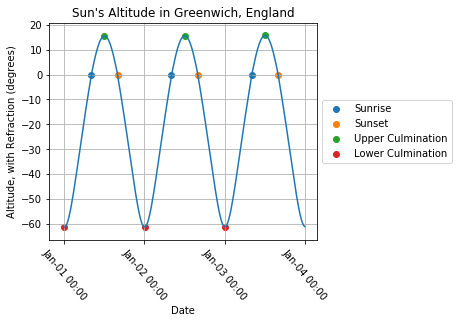

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

time_range = ts.utc(2018, 1, linspace(1, 4, 200))
rise_times = risings_settings(greenwich, sun, time_range, kind='rise')
set_times = risings_settings(greenwich, sun, time_range, kind='set')
upper_times = culminations(greenwich, sun, time_range)
lower_times = culminations(greenwich, sun, time_range, kind='lower')

altitudes = greenwich.at(time_range).observe(sun).apparent().altaz('standard')[0]
rise_alts = greenwich.at(rise_times).observe(sun).apparent().altaz('standard')[0]
set_alts = greenwich.at(set_times).observe(sun).apparent().altaz('standard')[0]
upper_alts = greenwich.at(upper_times).observe(sun).apparent().altaz('standard')[0]
lower_alts = greenwich.at(lower_times).observe(sun).apparent().altaz('standard')[0]

fig, ax = plt.subplots()

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.plot(time_range.tt, altitudes.degrees)
ax.scatter(rise_times.tt, rise_alts.degrees, label='Sunrise')
ax.scatter(set_times.tt, set_alts.degrees, label='Sunset')
ax.scatter(upper_times.tt, upper_alts.degrees, label='Upper Culmination')
ax.scatter(lower_times.tt, lower_alts.degrees, label='Lower Culmination')

ax.set_title("Sun's Altitude in Greenwich, England")
ax.set_ylabel('Altitude, with Refraction (degrees)')
ax.set_xlabel('Date')
label_times = ts.utc(2018, 1, arange(1, 5))
ax.set_xticks(label_times.tt)
ax.set_xticklabels([x[10:22] for x in label_times.utc_jpl()], {'rotation':-50})
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

plt.show()

### Plotting Culminations, Risings, and Settings of the ISS

We can do the same thing with an `EarthSatellite` object:

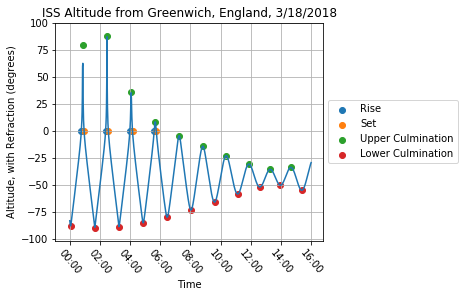

In [33]:
time_range = ts.utc(2018, 3, 18, linspace(0, 16, 1000))
rise_times = risings_settings(greenwich, ISS, time_range, kind='rise')
set_times = risings_settings(greenwich, ISS, time_range, kind='set')
upper_times = culminations(greenwich, ISS, time_range)
lower_times = culminations(greenwich, ISS, time_range, kind='lower')

geometric_vector = ISS - greenwich

altitudes = geometric_vector.at(time_range).altaz('standard')[0]
rise_alts = geometric_vector.at(rise_times).altaz('standard')[0]
set_alts = geometric_vector.at(set_times).altaz('standard')[0]
upper_alts = geometric_vector.at(upper_times).altaz('standard')[0]
lower_alts = geometric_vector.at(lower_times).altaz('standard')[0]

fig, ax = plt.subplots()

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.plot(time_range.tt, altitudes.degrees)
ax.scatter(rise_times.tt, rise_alts.degrees, label='Rise')
ax.scatter(set_times.tt, set_alts.degrees, label='Set')
ax.scatter(upper_times.tt, upper_alts.degrees, label='Upper Culmination')
ax.scatter(lower_times.tt, lower_alts.degrees, label='Lower Culmination')

ax.set_title("ISS Altitude from Greenwich, England, 3/18/2018")
ax.set_ylabel('Altitude, with Refraction (degrees)')
ax.set_xlabel('Time')
label_times = ts.utc(2018, 3, 18, arange(0, 17, 2))
ax.set_xticks(label_times.tt)
ax.set_xticklabels([x[17:22] for x in label_times.utc_jpl()], {'rotation':-50})
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

plt.show()

### Plot change in the sun's azimuth at sunrise over time

In [34]:
time_range = ts.utc(2018, arange(0,8))

sunrise_times = risings_settings(greenwich, sun, time_range, kind='rise')

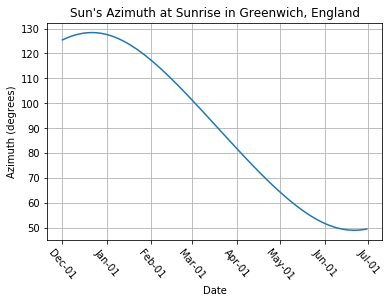

In [35]:
azimuths = greenwich.at(sunrise_times).observe(sun).apparent().altaz()[1]

fig, ax = plt.subplots()
ax.plot(sunrise_times.tt, azimuths.degrees)
ax.set_title("Sun's Azimuth at Sunrise in Greenwich, England")
ax.set_ylabel('Azimuth (degrees)')
ax.set_xlabel('Date')
ax.set_xticks(time_range.tt)
ax.set_xticklabels([x[10:16] for x in time_range.utc_jpl()], {'rotation':-50})
plt.grid()
plt.show()

## Tests
Here are three functions that we can use for testing the times returned by these `culminations` and `settings_risings`. The first is `compare`, which is basically identical to the the `compare` function from the Skyfield tests. The other two require more explanation.

`is_root` tests a scalar time or a vector of times and determines if the target value f(t) is between f(t + epsilon) and f(t - epsilon). Returns true if all timees are a root within epsilon.

`is extreme` tests a scalar time or a vector of times and determines if both f(t + epsilon) and f(t - epsilon) are both below f(t), (meaning t is a local maximum) or if they are both above f(t) (meaning t is a local minimum). Returns true if all times are either a minimum or maximum within epsilon.

In [36]:
def compare(value, expected_value, epsilon):
    if hasattr(value, '__len__') or hasattr(expected_value, '__len__'):
        assert max(abs(value - expected_value)) <= epsilon
    else:
        assert abs(value - expected_value) <= epsilon


def is_root(f, times, target_f, epsilon):
    left_times = times - epsilon
    right_times = times + epsilon
    left_f = (f(left_times) - target_f + 180)%360 - 180
    right_f = (f(right_times) - target_f + 180)%360 - 180
    
    success_increasing = (left_f <= 0) * (right_f >= 0)
    success_decreasing = (left_f >= 0) * (right_f <= 0)
    success = success_increasing + success_decreasing
    
    if isinstance(success, ndarray):
        return success.all()
    else:
        return success

    
def is_extreme(f, times, epsilon):
    left_times = times - epsilon
    right_times = times + epsilon
    center_f = f(times)
    left_f = (f(left_times) - center_f + 180)%360 - 180
    right_f = (f(right_times) - center_f + 180)%360 - 180
    
    is_max = (left_f <= 0) * (right_f <= 0)
    is_min = (left_f >= 0) * (right_f >= 0)
    success = is_max + is_min
    
    if isinstance(success, ndarray):
        return success.all()
    else:
        return success

Now we can use these functions to test `culminations` and `risings_settings` with the sun, moon, and ISS. I don't know of any official data for culmination times to test against.

In [37]:
minute = 1/24/60
sec = minute/60
ms = sec/1000

def test_sun_culminations():
    time_range = ts.utc(2017, 1, [1, 32])
    times = culminations(greenwich, sun, time_range, 'all')
    
    assert isinstance(times, Time)
    assert len(times) == 62
    
    upper_times = culminations(greenwich, sun, time_range, 'upper')
    lower_times = culminations(greenwich, sun, time_range, 'lower')
    all_times = concatenate([upper_times.tt, lower_times.tt])
    all_times.sort()
    assert (times.tt == all_times).all()
    
    # Check that the found times produce the correct data
    f = partial(_alt, greenwich, sun)        
    assert is_extreme(f, times.tt, 2*ms)
    
    # Check that same result is found if plain Topos is used as observer
    times2 = culminations(greenwich.positives[-1], sun, time_range, 'all')
    assert (times.tt == times2.tt).all()
    print('pass')
    
    
def test_moon_culminations():
    time_range = ts.utc(2017, 1, [1, 32])
    times = culminations(greenwich, moon, time_range, 'all')
    
    assert isinstance(times, Time)
    assert len(times) == 60
    
    upper_times = culminations(greenwich, moon, time_range, 'upper')
    lower_times = culminations(greenwich, moon, time_range, 'lower')
    all_times = concatenate([upper_times.tt, lower_times.tt])
    all_times.sort()
    assert (times.tt == all_times).all()

    # Check that the found times produce the correct data
    f = partial(_alt, greenwich, moon)    
    assert is_extreme(f, times.tt, 6*ms)
    
    # Check that same result is found if plain Topos is used as observer
    times2 = culminations(greenwich.positives[-1], moon, time_range, 'all')
    assert (times.tt == times2.tt).all()
    print('pass')
    

def test_ISS_culminations():
    time_range = ts.utc(2017, 1, [1, 2])
    times = culminations(greenwich, ISS, time_range, 'all')
    
    assert isinstance(times, Time)
    assert len(times) == 31

    upper_times = culminations(greenwich, ISS, time_range, 'upper')
    lower_times = culminations(greenwich, ISS, time_range, 'lower')
    all_times = concatenate([upper_times.tt, lower_times.tt])
    all_times.sort()
    assert (times.tt == all_times).all()

    # Check that the found times produce the correct data
    f = partial(_satellite_alt, greenwich.positives[-1], ISS.positives[-1])
    assert is_extreme(f, times.tt, 2*ms)
    print('pass')
    
test_sun_culminations()
test_moon_culminations()
test_ISS_culminations()

pass
pass
pass


Official sunrise/set and moonrise/set times are available from the USNO. Here are links to sources of the data that are used below:

* http://aa.usno.navy.mil/cgi-bin/aa_rstablew.pl?ID=AA&year=2017&task=0&place=Greenwich&lon_sign=-1&lon_deg=0&lon_min=0&lat_sign=1&lat_deg=51&lat_min=30&tz=&tz_sign=-1
* http://aa.usno.navy.mil/cgi-bin/aa_rstablew.pl?ID=AA&year=2017&task=1&place=Greenwich&lon_sign=-1&lon_deg=0&lon_min=0&lat_sign=1&lat_deg=51&lat_min=30&tz=&tz_sign=-1


In [38]:
# Data Source:
# http://aa.usno.navy.mil/cgi-bin/aa_rstablew.pl?ID=AA&year=2017&task=0&place=Greenwich&lon_sign=-1&lon_deg=0&lon_min=0&lat_sign=1&lat_deg=51&lat_min=30&tz=&tz_sign=-1
def test_sun_risings_settings():
    time_range = ts.utc(2017, 1, [1, 32])    
    times = risings_settings(greenwich, sun, time_range)
    
    assert isinstance(times, Time)
    assert len(times) == 62
    
    compare(times[0].tt, ts.utc(2017, 1, 1, 8, 6).tt, minute/2)
    
    rise_times = risings_settings(greenwich, sun, time_range, 'rise')
    set_times = risings_settings(greenwich, sun, time_range, 'set')
    all_times = concatenate([rise_times.tt, set_times.tt])
    all_times.sort()
    assert (times.tt == all_times).all()
    
    # Check that the found times produce the correct data    
    f = partial(_alt, greenwich, sun)
    assert is_root(f, times.tt, -50/60, ms/2)
    
    # Check that same result is found if plain Topos is used as observer
    times2 = risings_settings(greenwich.positives[-1], sun, time_range)
    assert (times.tt == times2.tt).all()
    print('pass')


# Data Source:   
# http://aa.usno.navy.mil/cgi-bin/aa_rstablew.pl?ID=AA&year=2017&task=1&place=Greenwich&lon_sign=-1&lon_deg=0&lon_min=0&lat_sign=1&lat_deg=51&lat_min=30&tz=&tz_sign=-1
def test_moon_risings_settings():
    time_range = ts.utc(2017, 1, [1, 32])
    times = risings_settings(greenwich, moon, time_range)
    
    assert isinstance(times, Time)
    assert len(times) == 60
    
    compare(times[0].tt, ts.utc(2017, 1, 1, 9, 46).tt, minute/2)
    
    rise_times = risings_settings(greenwich, moon, time_range, 'rise')
    set_times = risings_settings(greenwich, moon, time_range, 'set')
    all_times = concatenate([rise_times.tt, set_times.tt])
    all_times.sort()
    assert (times.tt == all_times).all() 
    
    # Check that the found times produce the correct data
    f = partial(_moon_ul_alt, greenwich, earth, moon)
    assert is_root(f, times.tt, -34/60, ms/2)
    
    # Check that same result is found if plain Topos is used as observer
    times2 = risings_settings(greenwich.positives[-1], moon, time_range)
    assert (times.tt == times2.tt).all()
    print('pass')
    
    
def test_ISS_risings_settings():
    time_range = ts.utc(2017, 1, [1, 2])
    times = risings_settings(greenwich, ISS, time_range)
    
    assert isinstance(times, Time)
    assert len(times) == 12
    
    rise_times = risings_settings(greenwich, ISS, time_range, 'rise')
    set_times = risings_settings(greenwich, ISS, time_range, 'set')
    all_times = concatenate([rise_times.tt, set_times.tt])
    all_times.sort()
    assert (times.tt == all_times).all() 
    
    # Check that the found times produce the correct data
    f = partial(_satellite_alt, greenwich.positives[-1], ISS.positives[-1])
    assert is_root(f, times.tt, -34/60, ms/2)
    print('pass')
    
test_sun_risings_settings()
test_moon_risings_settings()
test_ISS_risings_settings()

pass
pass
pass
